In this notebook we'll take a closer look at our data to better understand it and generate useful features for modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

shows = pd.read_pickle("cleaned_dataset.pkl")

In [2]:
shows.columns

Index(['genre', 'link', 'network', 'status', 'tagline', 'title', 'years',
       'start_year', 'end_year', 'synopsis', 'primary_genre',
       'secondary_genre', 'Comedy', 'Drama', 'Game Show', 'Reality', 'Sci-fi',
       'Talk', 'Crime', 'Action', 'Fantasy', 'Animated', 'Horror', 'Legal',
       'Medical', 'tvmaze_rating', 'tvmaze_runtime', 'tvmaze_ep_day',
       'imdb_actors', 'imdb_awards', 'imdb_country', 'imdb_director',
       'imdb_genre', 'imdb_language', 'imdb_plot', 'imdb_rated',
       'imdb_runtime', 'imdb_website', 'imdb_writer', 'imdb_year',
       'imdb_rating', 'imdb_votes', 'imdb_totalseasons', 'prem_date',
       'quarter', 'month', 'yr_quarter', 'yr_mo', 'yrs_run',
       'one_season_cancel', 'two_season_cancel', 'three_season_cancel'],
      dtype='object')

In [3]:
shows.head(3)

,genre,link,network,status,tagline,title,years,start_year,end_year,synopsis,...,imdb_totalseasons,prem_date,quarter,month,yr_quarter,yr_mo,yrs_run,one_season_cancel,two_season_cancel,three_season_cancel
0,Comedy,http://www.ismyshowcancelled.com/show/2010/ble...,CBS,Cancelled,"A sitcom based on the Twitter feed ""S*** My Da...",$#*! My Dad Says,2010 - 2011,2010,2011.0,Ed is an opinionated and divorced 72-year-old ...,...,1.0,2010-09-23,3,9,2010Q3,2010-09,1.0,1,1,1
1,Drama / Crime,http://www.ismyshowcancelled.com/show/2018/100...,WGN America,Coming Soon,A thriller following an New York cop who trave...,100 Code,2018 - Present,2018,NaN,NYPD Detective Tommy Conley travels to Sweden ...,...,1.0,2018-05-29,2,5,2018Q2,2018-05,1.0,0,0,0
2,Game Show,http://www.ismyshowcancelled.com/show/2011/101...,ABC,Cancelled,A game show competition where contestants are ...,101 Ways to Leave a Gameshow,2011 - 2011,2011,2011.0,"In 101 Ways to Leave a Game Show, contestants ...",...,NaN,2010-07-11,3,7,2010Q3,2010-07,1.0,1,1,1


Let's explore how seasonality cancellation varies by some different characteristics

#### By year

In [4]:
annual_cancelled = pd.DataFrame(shows[shows['status'] != 'Coming Soon'].groupby('start_year')['one_season_cancel','two_season_cancel','three_season_cancel'].sum())
yr_counts = pd.DataFrame(shows.groupby('start_year')['start_year'].count()).rename({'start_year':'total_shows'},axis=1)
annual_cancelled = annual_cancelled.join(yr_counts,how='left',lsuffix='_left', rsuffix='_right')

In [5]:
annual_cancelled.iloc[20]

one_season_cancel       0
two_season_cancel       1
three_season_cancel     2
total_shows            20
Name: 2004, dtype: int64

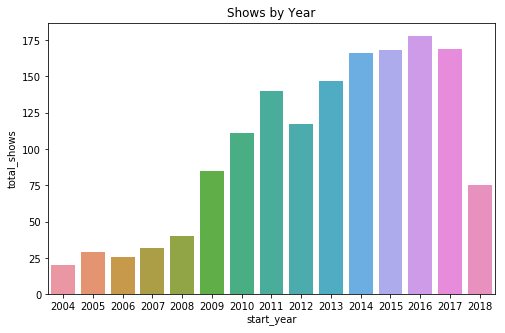

In [7]:
annual_cancelled_subset = annual_cancelled.iloc[20:]
plt.figure(figsize=(8,5))
sns.barplot(x=annual_cancelled_subset.index, y=annual_cancelled_subset['total_shows'])
plt.title("Shows by Year")
plt.savefig("Extras/showsbyyear.png")
plt.show()

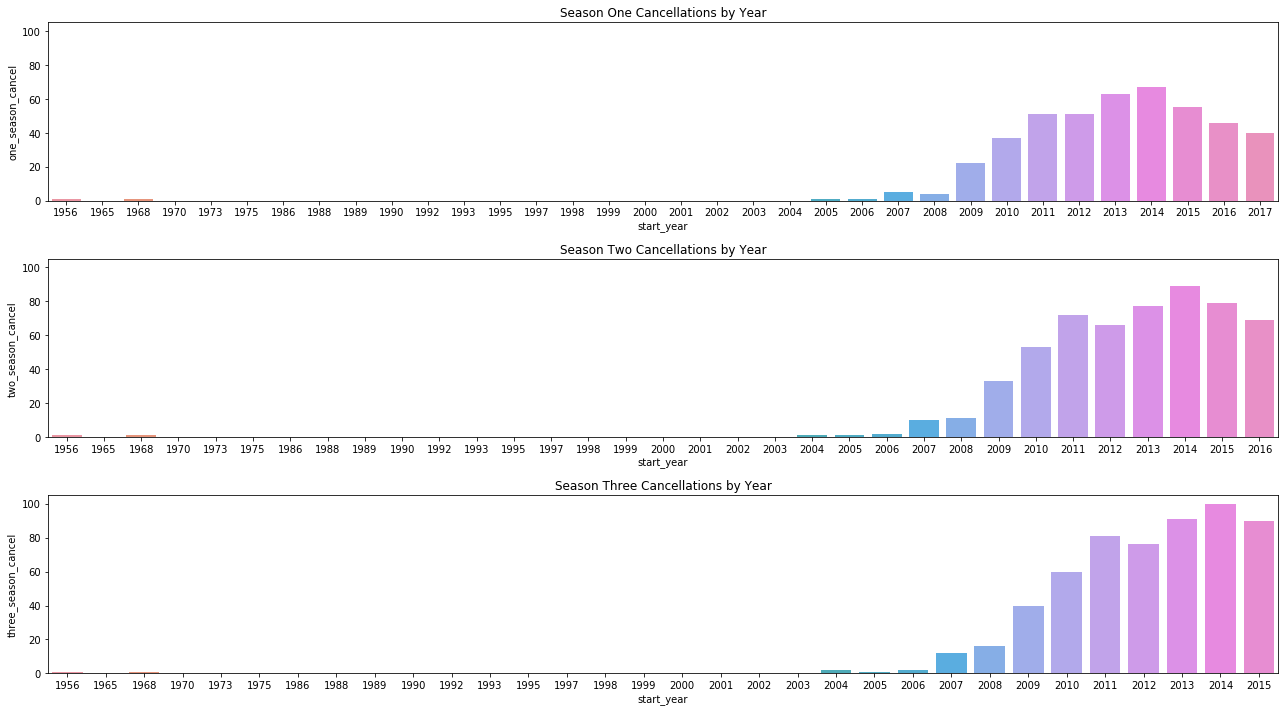

In [8]:
# Plotting out the cancellation rate before x seasons by year
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(18,10),sharey=True)
sns.barplot(x=annual_cancelled.index,y=annual_cancelled['one_season_cancel'],ax=ax1)
ax1.set_title("Season One Cancellations by Year")
ax1.set_xlim(-0.5,len(annual_cancelled)-1.5)
sns.barplot(x=annual_cancelled.index,y=annual_cancelled['two_season_cancel'],ax=ax2)
ax2.set_title("Season Two Cancellations by Year")
ax2.set_xlim(-0.5,len(annual_cancelled)-2.5)
sns.barplot(x=annual_cancelled.index,y=annual_cancelled['three_season_cancel'],ax=ax3)
ax3.set_title("Season Three Cancellations by Year")
ax3.set_xlim(-0.5,len(annual_cancelled)-3.5)
plt.tight_layout()
plt.show()

Cancellations seem to increase by year before decreasing a bit recently. We know that there are more shows in general though, so instead we should look at this in terms of percentages. Note that years at the end are clipped depending on the chart, since for example shows airing in 2017 are not eligible to have been cancelled within two years of their premiere.

In [9]:
annual_cancelled['pct_one_canc'] = annual_cancelled['one_season_cancel']/annual_cancelled['total_shows']
annual_cancelled['pct_two_canc'] = annual_cancelled['two_season_cancel']/annual_cancelled['total_shows']
annual_cancelled['pct_three_canc'] = annual_cancelled['three_season_cancel']/annual_cancelled['total_shows']

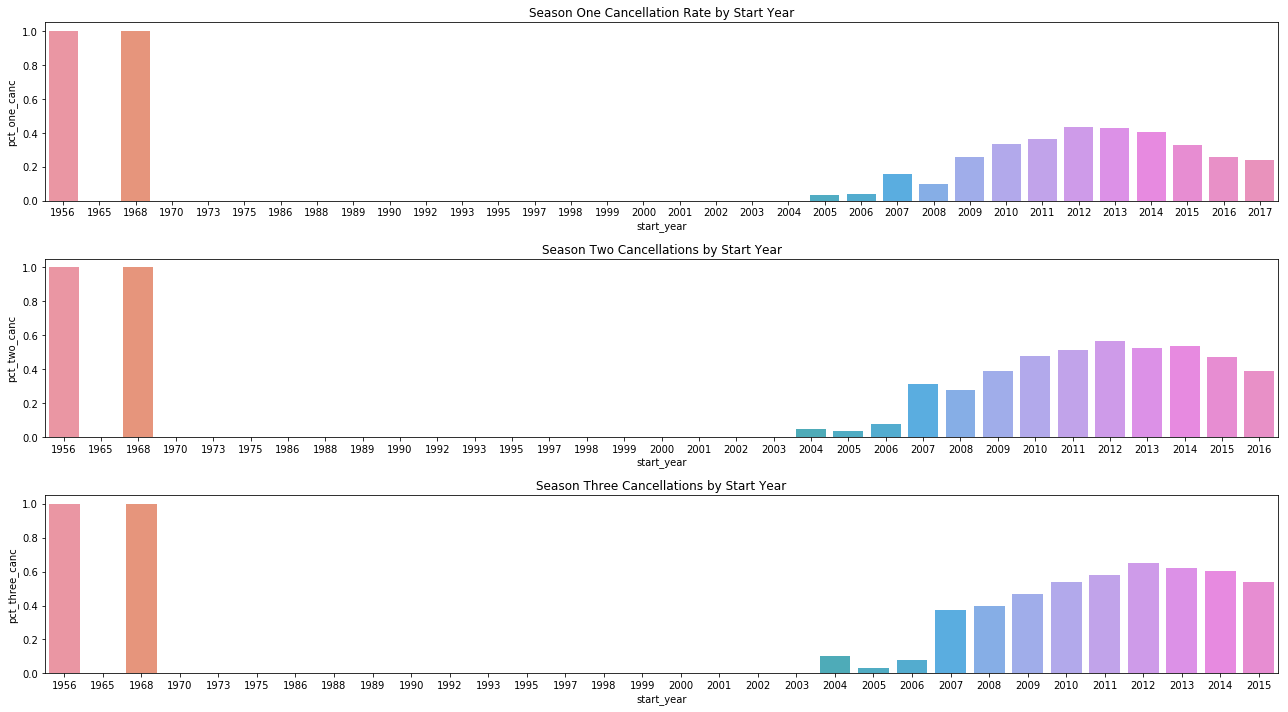

In [10]:
# Plotting out the cancellation rate before x seasons by year
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(18,10),sharey=True)
sns.barplot(x=annual_cancelled.index,y=annual_cancelled['pct_one_canc'],ax=ax1)
ax1.set_title("Season One Cancellation Rate by Start Year")
ax1.set_xlim(-0.5,len(annual_cancelled)-1.5)
sns.barplot(x=annual_cancelled.index,y=annual_cancelled['pct_two_canc'],ax=ax2)
ax2.set_title("Season Two Cancellations by Start Year")
ax2.set_xlim(-0.5,len(annual_cancelled)-2.5)
sns.barplot(x=annual_cancelled.index,y=annual_cancelled['pct_three_canc'],ax=ax3)
ax3.set_title("Season Three Cancellations by Start Year")
ax3.set_xlim(-0.5,len(annual_cancelled)-3.5)
plt.tight_layout()
plt.show()

Really interesting. So it looks like cancellation rates peaked from 2012-2014 (along with total volume of cancellations), and that has tapered off a bit in the last couple years. So year may be a useful variable in our supervised model.

#### By network

In [11]:
net_cancelled = pd.DataFrame(shows[shows['status']!='Coming Soon'].\
                             groupby('network')['one_season_cancel','two_season_cancel','three_season_cancel'].sum())
net_counts = pd.DataFrame(shows.groupby('network')['network'].count()).rename({'network':'total_shows'},axis=1)
net_cancelled = net_cancelled.join(net_counts,how='left',lsuffix='_left', rsuffix='_right')
net_cancelled['pct_one_canc'] = net_cancelled['one_season_cancel']/net_cancelled['total_shows']
net_cancelled['pct_two_canc'] = net_cancelled['two_season_cancel']/net_cancelled['total_shows']
net_cancelled['pct_three_canc'] = net_cancelled['three_season_cancel']/net_cancelled['total_shows']

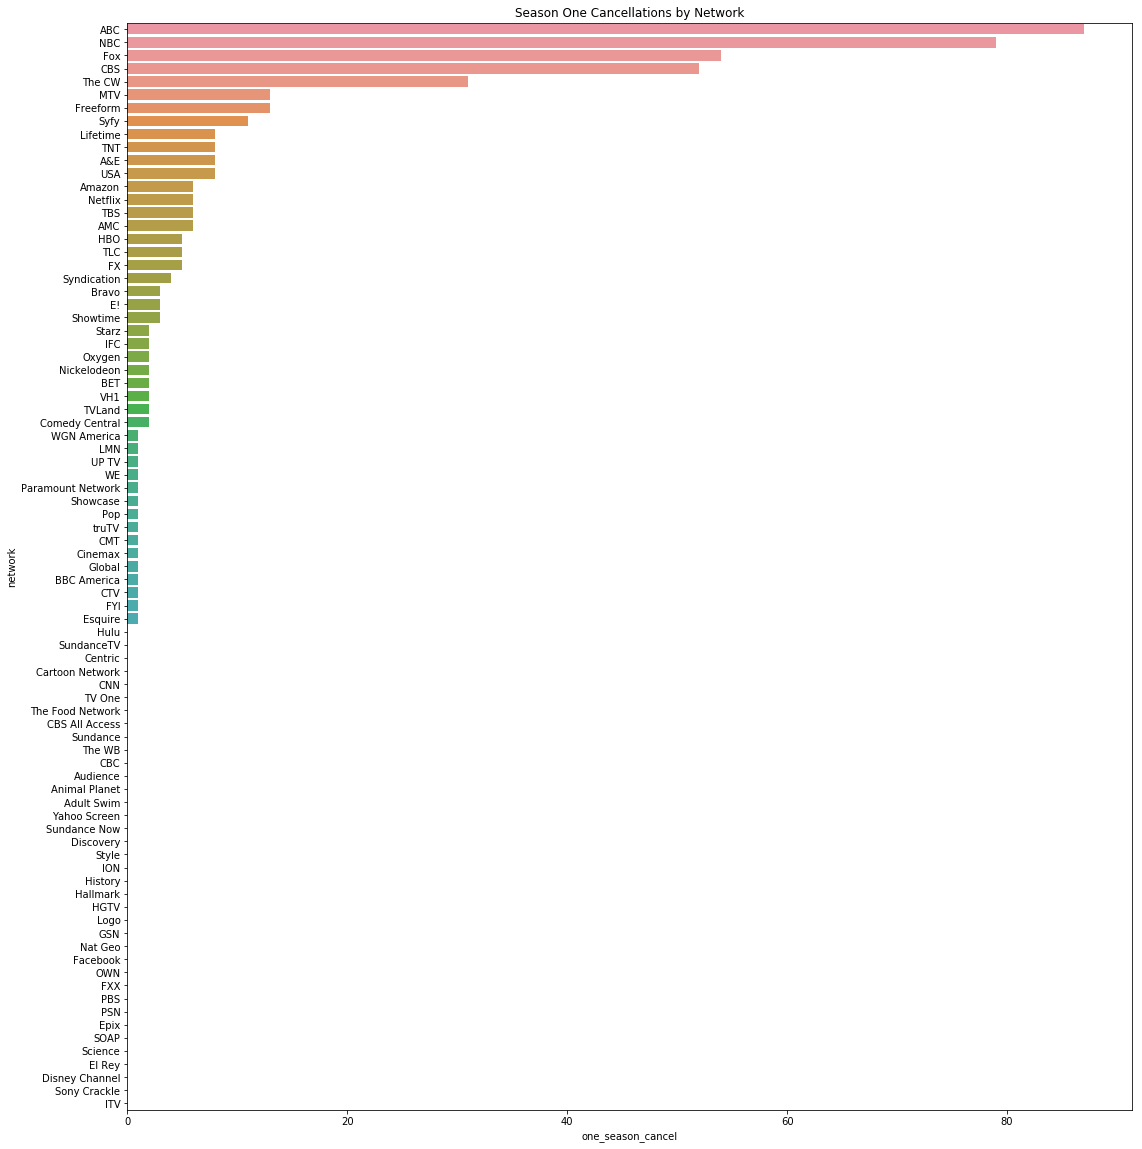

In [12]:
# Plotting out the cancellation rate before x seasons by net
fig, ax1 = plt.subplots(1,1,figsize=(18,20),sharey=True)

net_cancelled = net_cancelled.sort_values('one_season_cancel',ascending=False).reset_index()

sns.barplot(y='network',x='one_season_cancel',data=net_cancelled,order=net_cancelled['network'],ax=ax1)
ax1.set_title("Season One Cancellations by Network")

plt.show()

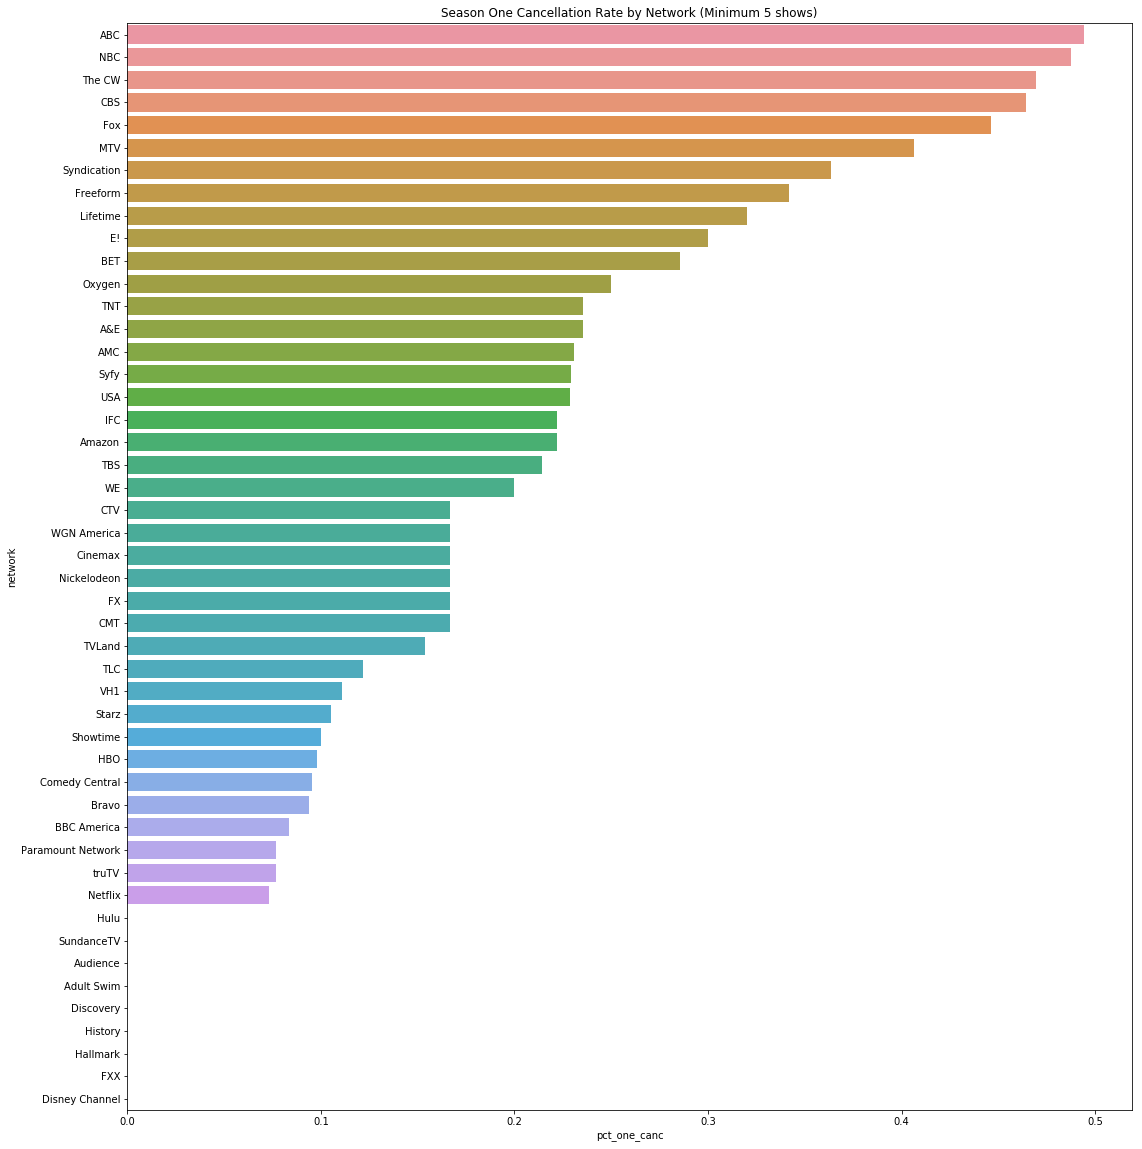

In [13]:
# Plotting out the cancellation rate before x seasons by net
fig, ax1 = plt.subplots(1,1,figsize=(18,20),sharey=True)

min5_shows = net_cancelled[net_cancelled['total_shows'] >= 5]
min5_shows = min5_shows.sort_values('pct_one_canc',ascending=False)

sns.barplot(y='network',x='pct_one_canc',data=min5_shows, order=min5_shows['network'],ax=ax1)
ax1.set_title("Season One Cancellation Rate by Network (Minimum 5 shows)")

plt.show()

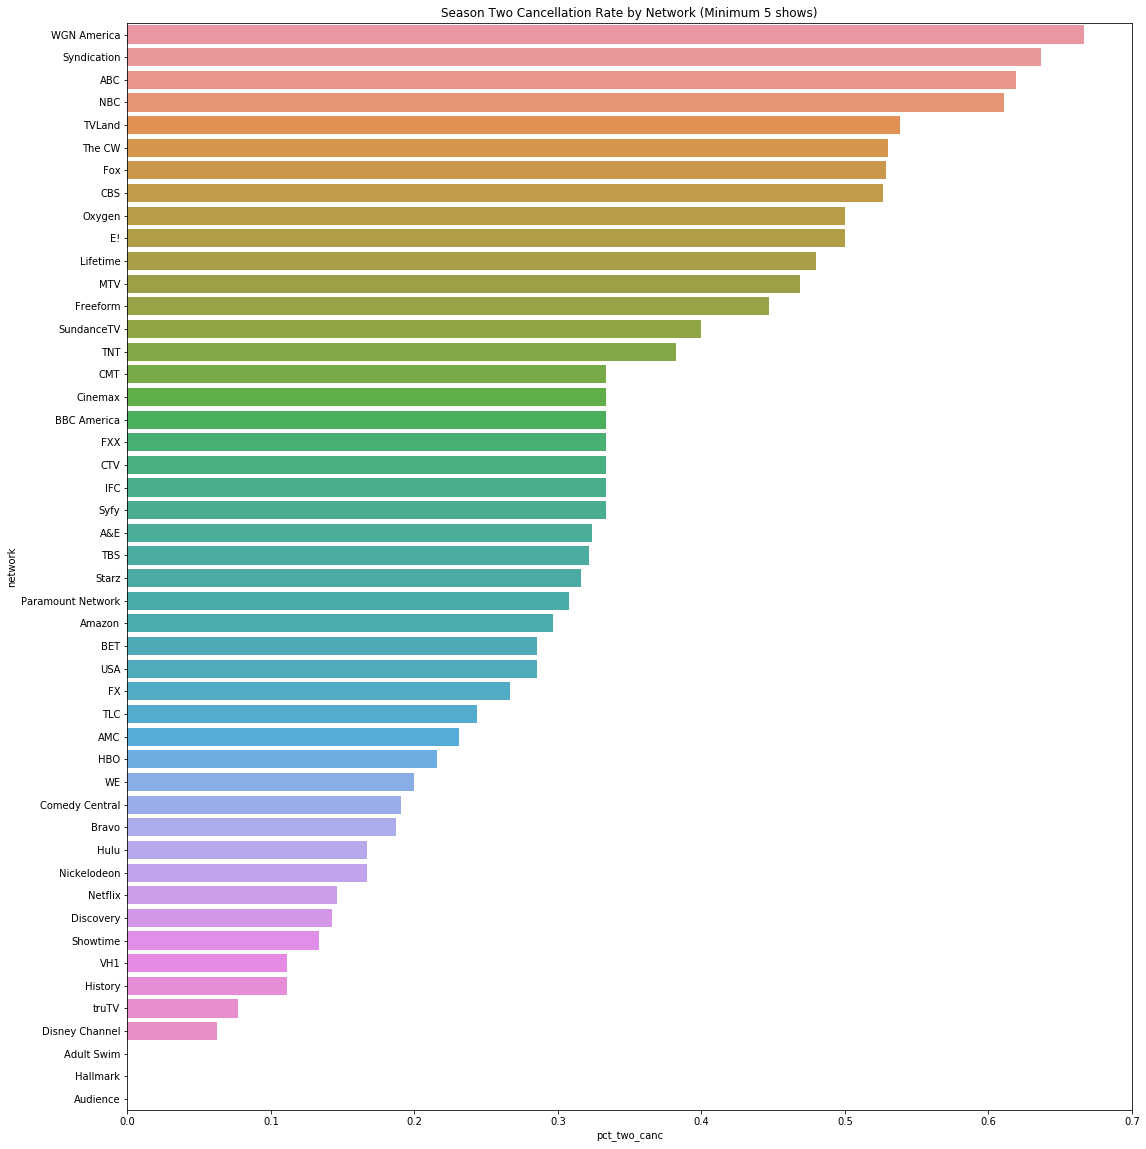

In [14]:
# Plotting out the cancellation rate before x seasons by net
fig, ax1 = plt.subplots(1,1,figsize=(18,20),sharey=True)

min5_shows = net_cancelled[net_cancelled['total_shows'] >= 5]
min5_shows = min5_shows.sort_values('pct_two_canc',ascending=False)

sns.barplot(y='network',x='pct_two_canc',data=min5_shows, order=min5_shows['network'],ax=ax1)
ax1.set_title("Season Two Cancellation Rate by Network (Minimum 5 shows)")

plt.show()

Big broadcast networks and a few underperformers on cable tend to have the highest cancellation rate and total volume of cancellations. Let's create a couple quick flags for network type, as well as define a feature for "problem" networks with a cancellation rate at the 75th percentile or above.

In [15]:
shows['broadcast_flag'] = np.where(shows['network'].isin(['ABC','CBS','NBC','The CW','Fox']),1,0)
shows['streaming_flag'] = np.where(shows['network'].isin(['Hulu','Netflix','Amazon','Yahoo Screen',\
                                                          'Facebook','Sony Crackle','CBS All Access']),1,0)
shows['premium_cable_flag'] = np.where(shows['network'].isin(['HBO','Cinemax','Showtime','Epix','Starz']),1,0)

# We'll count as basic cable if none of the other labels apply
net_flags = ['broadcast_flag','streaming_flag','premium_cable_flag']
shows['basic_cable_flag'] = np.where(shows[net_flags].max(axis=1) == 0,1,0)
net_flags = ['broadcast_flag','streaming_flag','premium_cable_flag','basic_cable_flag']

In [16]:
shows['network_type'] = shows[net_flags].idxmax(axis=1).str.replace('_flag','')

net_type_cancelled = pd.DataFrame(shows[shows['status']!='Coming Soon'].groupby('network_type')['one_season_cancel','two_season_cancel','three_season_cancel'].sum())
net_type_counts = pd.DataFrame(shows.groupby('network_type')['network_type'].count()).rename({'network_type':'total_shows'},axis=1)
net_type_cancelled = net_type_cancelled.join(net_type_counts,how='left',lsuffix='_left', rsuffix='_right')
net_type_cancelled['pct_one_canc'] = net_type_cancelled['one_season_cancel']/net_type_cancelled['total_shows']
net_type_cancelled['pct_two_canc'] = net_type_cancelled['two_season_cancel']/net_type_cancelled['total_shows']
net_type_cancelled['pct_three_canc'] = net_type_cancelled['three_season_cancel']/net_type_cancelled['total_shows']

In [17]:
net_type_cancelled

,one_season_cancel,two_season_cancel,three_season_cancel,total_shows,pct_one_canc,pct_two_canc,pct_three_canc
network_type,,,,,,,
basic_cable,129,207,256,688,0.187500,0.300872,0.372093
broadcast,303,366,384,637,0.475667,0.574568,0.602826
premium_cable,11,24,33,109,0.100917,0.220183,0.302752
streaming,12,23,26,137,0.087591,0.167883,0.189781


In [18]:
net_type_cancelled = net_type_cancelled.sort_values('pct_two_canc',ascending=False).reset_index()

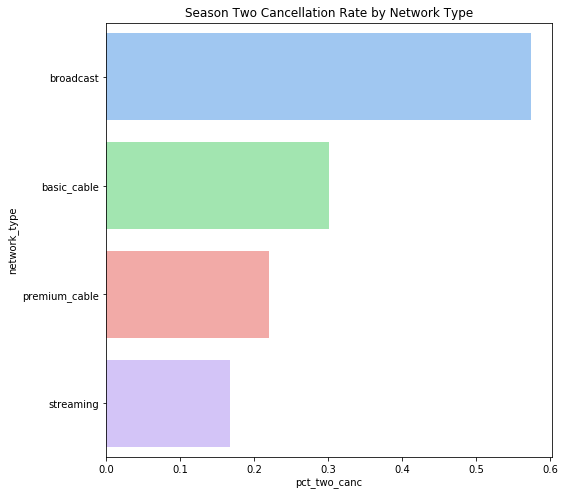

In [19]:
# Plotting out the cancellation rate before x seasons by network type
fig, ax1 = plt.subplots(1,1,figsize=(8,8),sharey=True)

sns.barplot(y='network_type',x='pct_two_canc',data=net_type_cancelled, order=net_type_cancelled['network_type'],palette='pastel')
ax1.set_title("Season Two Cancellation Rate by Network Type")
plt.savefig("Extras/net_type_canc.png",bbox_inches='tight')
plt.show()

Interesting, the cancellation rate is much higher for broadcast networks. Streaming and premium cable nets seem to be more forgiving, which jives with what we know anecdotally. Let's quickly just add the "problem" network flag as defined above.

In [20]:
np.percentile(net_cancelled['pct_one_canc'],75)

0.2330316742081448

In [21]:
net_cancelled['risky_1season'] = np.where(net_cancelled['pct_one_canc'] >= \
                                          np.percentile(net_cancelled['pct_one_canc'],75),1,0)
net_cancelled['risky_2season'] = np.where(net_cancelled['pct_two_canc'] >= \
                                          np.percentile(net_cancelled['pct_two_canc'],75),1,0)
net_cancelled['risky_3season'] = np.where(net_cancelled['pct_three_canc'] >= \
                                          np.percentile(net_cancelled['pct_three_canc'],75),1,0)

In [22]:
net_cancelled.to_pickle("network_cancellations.pkl")

In [23]:
net_cancelled.dtypes

network                category
one_season_cancel         int64
two_season_cancel         int64
three_season_cancel       int64
total_shows               int64
pct_one_canc            float64
pct_two_canc            float64
pct_three_canc          float64
risky_1season             int64
risky_2season             int64
risky_3season             int64
dtype: object

In [24]:
shows = pd.merge(shows,net_cancelled[['network','pct_one_canc','pct_two_canc','risky_1season','risky_2season','risky_3season']]\
                            ,how='left',on='network')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [25]:
shows = shows.reset_index(drop=True)
shows.to_pickle("cleaned_dataset_v2.pkl")
shows.head()

,genre,link,network,status,tagline,title,years,start_year,end_year,synopsis,...,broadcast_flag,streaming_flag,premium_cable_flag,basic_cable_flag,network_type,pct_one_canc,pct_two_canc,risky_1season,risky_2season,risky_3season
0,Comedy,http://www.ismyshowcancelled.com/show/2010/ble...,CBS,Cancelled,"A sitcom based on the Twitter feed ""S*** My Da...",$#*! My Dad Says,2010 - 2011,2010,2011.0,Ed is an opinionated and divorced 72-year-old ...,...,1,0,0,0,broadcast,0.464286,0.526786,1,1,1
1,Drama / Crime,http://www.ismyshowcancelled.com/show/2018/100...,WGN America,Coming Soon,A thriller following an New York cop who trave...,100 Code,2018 - Present,2018,NaN,NYPD Detective Tommy Conley travels to Sweden ...,...,0,0,0,1,basic_cable,0.166667,0.666667,0,1,1
2,Game Show,http://www.ismyshowcancelled.com/show/2011/101...,ABC,Cancelled,A game show competition where contestants are ...,101 Ways to Leave a Gameshow,2011 - 2011,2011,2011.0,"In 101 Ways to Leave a Game Show, contestants ...",...,1,0,0,0,broadcast,0.494318,0.619318,1,1,1
3,Drama / Sci-fi,http://www.ismyshowcancelled.com/show/2015/12-...,Syfy,On Air,A drama following a man sent back in time to p...,12 Monkeys,2015 - Present,2015,NaN,"By the year 2043, a deadly virus has wiped out...",...,0,0,0,1,basic_cable,0.229167,0.333333,0,0,0
4,Drama,http://www.ismyshowcancelled.com/show/2017/13-...,Netflix,On Air,A drama following the revelation of why a youn...,13 Reasons Why,2017 - Present,2017,NaN,Hannah Baker is a teenage girl who takes her o...,...,0,1,0,0,streaming,0.073171,0.146341,0,0,0


#### By genre

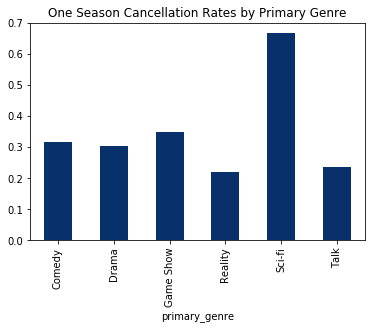

In [31]:
shows.groupby('primary_genre').mean()['one_season_cancel'].plot(kind='bar',cmap='Blues_r')
plt.title("One Season Cancellation Rates by Primary Genre")
plt.show()

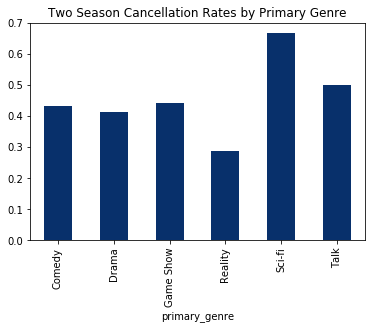

In [32]:
shows.groupby('primary_genre').mean()['two_season_cancel'].plot(kind='bar',cmap='Blues_r')
plt.title("Two Season Cancellation Rates by Primary Genre")
plt.show()

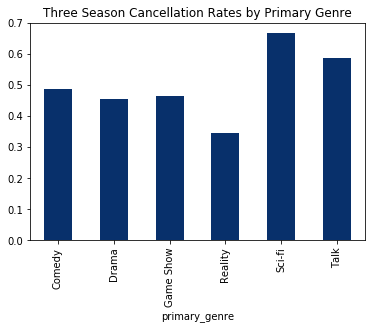

In [33]:
shows.groupby('primary_genre').mean()['three_season_cancel'].plot(kind='bar',cmap='Blues_r')
plt.title("Three Season Cancellation Rates by Primary Genre")
plt.show()

In [28]:
from scipy import stats
import itertools

In [36]:
for x,y in itertools.combinations(shows['primary_genre'].unique(),2):
    print(x,'/',y)
    print(stats.ttest_ind(shows[shows['primary_genre'] == x]['two_season_cancel'],shows[shows['primary_genre'] == y]['two_season_cancel']))
    print('\n')

Comedy / Drama
Ttest_indResult(statistic=0.59121074876614244, pvalue=0.55449621870920995)


Comedy / Game Show
Ttest_indResult(statistic=-0.13006862762546839, pvalue=0.89656281913854663)


Comedy / Reality
Ttest_indResult(statistic=4.2439849853308313, pvalue=2.4466130886355644e-05)


Comedy / Talk
Ttest_indResult(statistic=-0.77610483010330522, pvalue=0.43804898033922202)


Comedy / Sci-fi
Ttest_indResult(statistic=-0.8180429374356134, pvalue=0.41374197485789577)


Drama / Game Show
Ttest_indResult(statistic=-0.35819423409277218, pvalue=0.72030443026485858)


Drama / Reality
Ttest_indResult(statistic=3.9648432129894315, pvalue=7.8599123813500248e-05)


Drama / Talk
Ttest_indResult(statistic=-0.99042498108386035, pvalue=0.32230817763843933)


Drama / Sci-fi
Ttest_indResult(statistic=-0.88517082397289037, pvalue=0.37638206379112205)


Game Show / Reality
Ttest_indResult(statistic=2.0703730898718833, pvalue=0.039078415351005459)


Game Show / Talk
Ttest_indResult(statistic=-0.501950570782

In [ ]:
stats.ttest_ind()

Interesting. Sci-fi shows seem pretty likely to be canceled overall, while reality shows seem very durable. Talk shows are not very likely to be cancelled after one season, but don't do as well over a two or three season period. Statistical significance is only present between certain subgroups.

#### By Runtime

In [52]:
shows['runtime'] = shows['tvmaze_runtime'].fillna(shows['imdb_runtime'])
shows = shows.drop(['tvmaze_runtime','imdb_runtime'],axis=1)

In [9]:
# Only runtimes occuring more than 5 times in the data
shows_runtime_spec = shows.copy()
shows_runtime_spec['rt_count'] = shows_runtime_spec.groupby('runtime')['runtime'].transform('count')
shows_runtime_spec = shows_runtime_spec[shows_runtime_spec['rt_count'] >= 5]

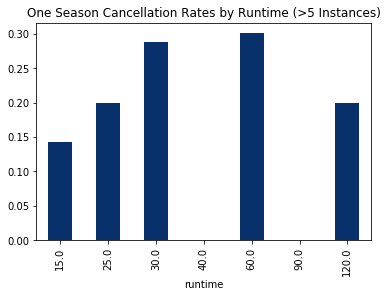

In [11]:
shows_runtime_spec.groupby('runtime').mean()['one_season_cancel'].plot(kind='bar',cmap='Blues_r')
plt.title("One Season Cancellation Rates by Runtime (>5 Instances)")
plt.show()

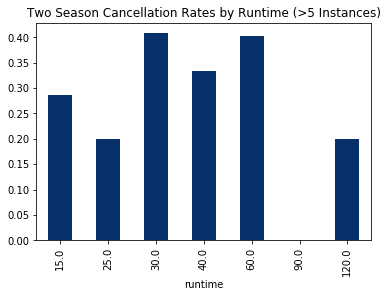

In [12]:
shows_runtime_spec.groupby('runtime').mean()['two_season_cancel'].plot(kind='bar',cmap='Blues_r')
plt.title("Two Season Cancellation Rates by Runtime (>5 Instances)")
plt.show()

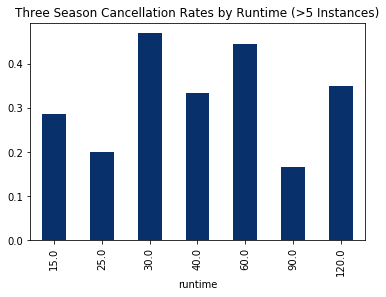

In [13]:
shows_runtime_spec.groupby('runtime').mean()['three_season_cancel'].plot(kind='bar',cmap='Blues_r')
plt.title("Three Season Cancellation Rates by Runtime (>5 Instances)")
plt.show()

In [7]:
#shows.to_pickle("cleaned_dataset_v2.pkl")
shows = pd.read_pickle("cleaned_dataset_v2.pkl")

30 and 60 minute shows, which constitute the bulk of the total, don't show a noticeable divergence in cancellation rates.

#### By time of year

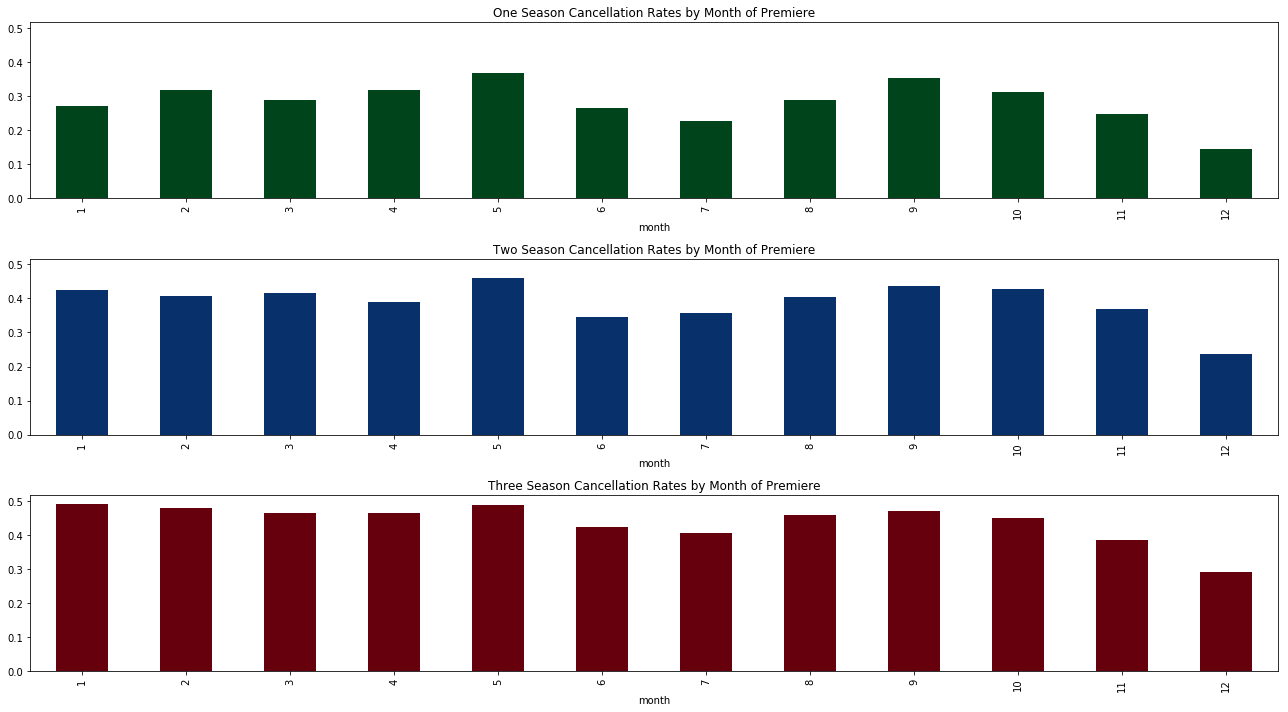

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(18,10),sharey=True)

ax1 = shows_runtime_spec.groupby('month').mean()['one_season_cancel'].plot(kind='bar',cmap='Greens_r',ax=ax1)
ax1.set_title("One Season Cancellation Rates by Month of Premiere")

ax2 = shows_runtime_spec.groupby('month').mean()['two_season_cancel'].plot(kind='bar',cmap='Blues_r',ax=ax2)
ax2.set_title("Two Season Cancellation Rates by Month of Premiere")

ax3 = shows_runtime_spec.groupby('month').mean()['three_season_cancel'].plot(kind='bar',cmap='Reds_r',ax=ax3)
ax3.set_title("Three Season Cancellation Rates by Month of Premiere")

plt.tight_layout()
plt.show()

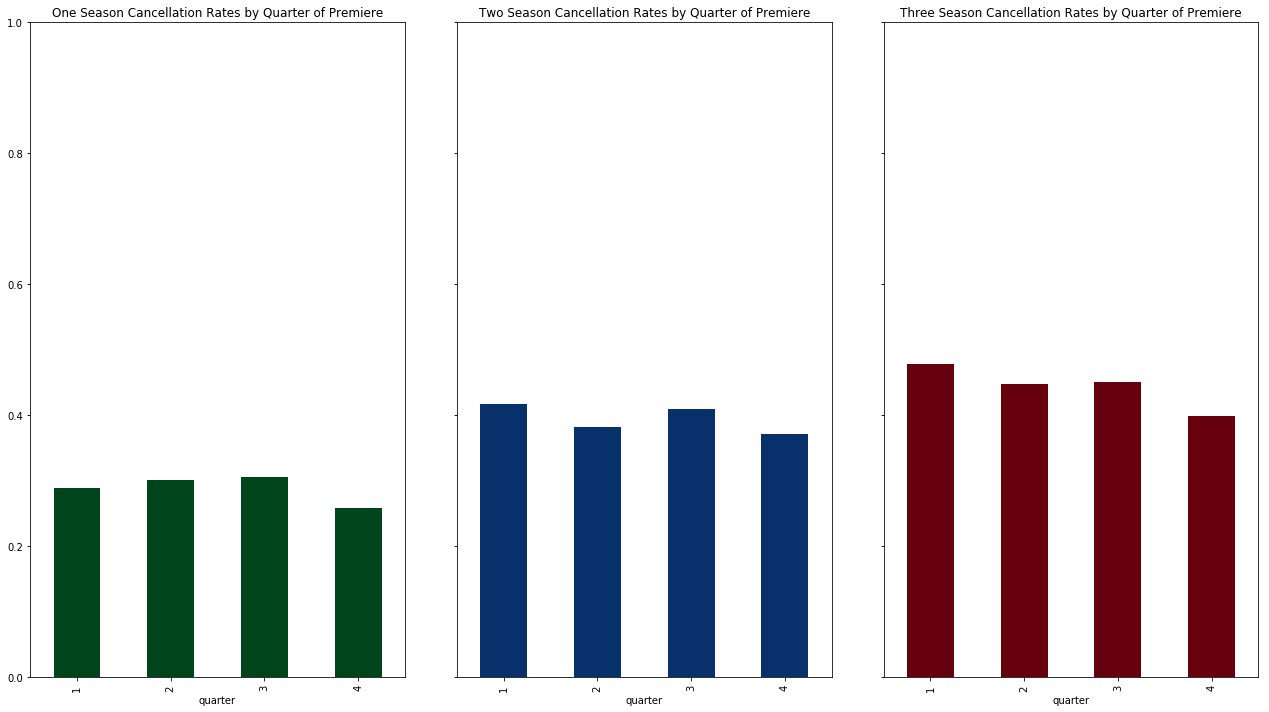

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,10),sharey=True)

ax1 = shows_runtime_spec.groupby('quarter').mean()['one_season_cancel'].plot(kind='bar',cmap='Greens_r',ax=ax1)
ax1.set_title("One Season Cancellation Rates by Quarter of Premiere")
ax1.set_ylim(0,1)

ax2 = shows_runtime_spec.groupby('quarter').mean()['two_season_cancel'].plot(kind='bar',cmap='Blues_r',ax=ax2)
ax2.set_title("Two Season Cancellation Rates by Quarter of Premiere")

ax3 = shows_runtime_spec.groupby('quarter').mean()['three_season_cancel'].plot(kind='bar',cmap='Reds_r',ax=ax3)
ax3.set_title("Three Season Cancellation Rates by Quarter of Premiere")

plt.tight_layout()
plt.show()

Cancellation rates are slightly higher for the fall season, but the differences are not substantial and disappear when the cancellation threshold is increased to 3 seasons.

#### By day of week

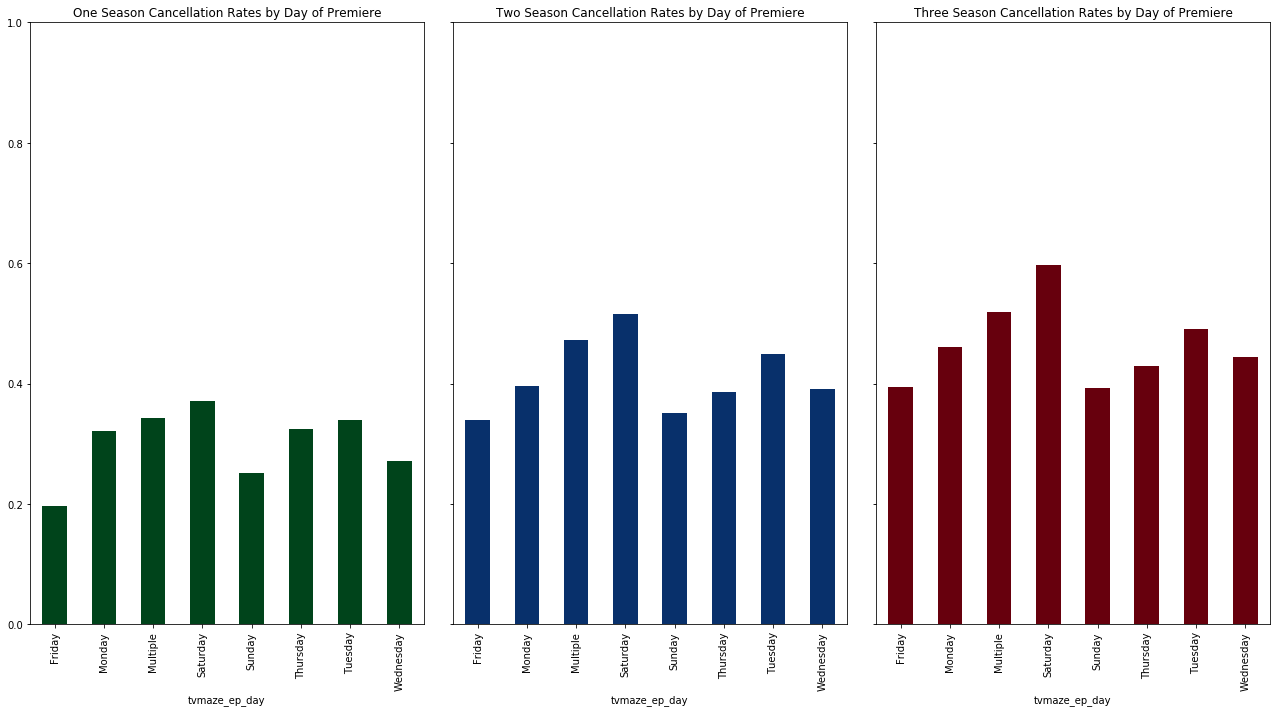

In [83]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,10),sharey=True)

ax1 = shows_runtime_spec.groupby('tvmaze_ep_day').mean()['one_season_cancel'].plot(kind='bar',cmap='Greens_r',ax=ax1)
ax1.set_title("One Season Cancellation Rates by Day of Premiere")
ax1.set_ylim(0,1)

ax2 = shows_runtime_spec.groupby('tvmaze_ep_day').mean()['two_season_cancel'].plot(kind='bar',cmap='Blues_r',ax=ax2)
ax2.set_title("Two Season Cancellation Rates by Day of Premiere")

ax3 = shows_runtime_spec.groupby('tvmaze_ep_day').mean()['three_season_cancel'].plot(kind='bar',cmap='Reds_r',ax=ax3)
ax3.set_title("Three Season Cancellation Rates by Day of Premiere")

plt.tight_layout()
plt.show()

In [84]:
shows['tvmaze_ep_day'].value_counts()

Wednesday    269
Tuesday      249
Sunday       245
Thursday     213
Friday       212
Monday       204
Multiple     111
Saturday      63
Name: tvmaze_ep_day, dtype: int64

Saturday shows are noticeably more likely to be cancelled, though this could be influenced by sample size. 

In [86]:
from scipy import stats

In [116]:
ep_day_lists = []
for day in shows['tvmaze_ep_day'].dropna().unique():
    subset = shows[shows['tvmaze_ep_day'] == day]['one_season_cancel'].values
    ep_day_lists.append(subset)

In [117]:
stats.f_oneway(ep_day_lists[0],ep_day_lists[1],ep_day_lists[2],ep_day_lists[3],ep_day_lists[4],ep_day_lists[5]\
              ,ep_day_lists[6],ep_day_lists[7])

F_onewayResult(statistic=2.85087224299094, pvalue=0.005877536098718823)

This does seem to be a significant difference, if we assume the distribution to be normal (it's not, it's Bernoulli).

In [30]:
no_na = shows[shows['tvmaze_ep_day'].notnull()]

In [33]:
for x,y in itertools.combinations(shows['tvmaze_ep_day'].unique(),2):
    print(x,'/',y)
    print(stats.ttest_ind(shows[shows['tvmaze_ep_day'] == x]['two_season_cancel'],shows[shows['tvmaze_ep_day'] == y]['two_season_cancel']))
    print('\n')

Thursday / Wednesday
Ttest_indResult(statistic=-0.0366674586725089, pvalue=0.9707653993595636)


Thursday / Saturday
Ttest_indResult(statistic=-1.7445681179645351, pvalue=0.0821813344227105)


Thursday / Friday
Ttest_indResult(statistic=1.1773876976816424, pvalue=0.23970282989797437)


Thursday / Monday
Ttest_indResult(statistic=-0.1500230310972329, pvalue=0.8808193292711076)


Thursday / Tuesday
Ttest_indResult(statistic=-1.3206451120364975, pvalue=0.18727637706731629)


Thursday / nan
Ttest_indResult(statistic=nan, pvalue=nan)


Thursday / Multiple
Ttest_indResult(statistic=-1.4484544644660757, pvalue=0.1484630356576717)


Thursday / Sunday
Ttest_indResult(statistic=0.7509101978855922, pvalue=0.4530940227537408)


Wednesday / Saturday
Ttest_indResult(statistic=-1.7655405269496387, pvalue=0.07839769699418753)


Wednesday / Friday
Ttest_indResult(statistic=1.2782191854704206, pvalue=0.2017911872690172)


Wednesday / Monday
Ttest_indResult(statistic=-0.12213548399420691, pvalue=0.902843

According to paired t-tests, some of the subgroups are statistically different from one another in their cancellation rates.

#### By language and country of origin

In [145]:
shows['imdb_language'].str.split(',').str.get(0).value_counts()

English       1538
Korean           3
Spanish          2
German           1
Swedish          1
Mandarin         1
Portuguese       1
Name: imdb_language, dtype: int64

Sadly, language won't be a particularly instructive variable. Almost all of our shows are in English (given that this is the US market), but perhaps it's possible to use country to indicate whether or not the series was an import or not, which may affect its popularity.

In [150]:
shows[shows['imdb_country'] == 'UK, Australia, New Zealand, USA']

,genre,link,network,status,tagline,title,years,start_year,end_year,synopsis,...,streaming_flag,premium_cable_flag,basic_cable_flag,network_type,pct_one_canc,pct_two_canc,risky_1season,risky_2season,risky_3season,runtime
1456,Drama / Crime,http://www.ismyshowcancelled.com/show/2013/top...,Sundance,On Air,A drama following a detective investigating th...,Top of the Lake,2013 - Present,2013,NaN,Detective Robbin Griffin is a police officer w...,...,0,0,1,basic_cable,0.0,0.0,0,0,0,60.0


In [202]:
def country_reclassifier(countries):
    if not isinstance(countries, str):
        new_class = np.nan
    elif len(countries.split(', ')) == 1:
        if countries in ['USA','UK','Canada','Australia','South Korea']:
            new_class = countries
        else:
            new_class = 'Other International'
    elif len(countries.split(', ')) > 1:
        new_class = 'Multiple'
        
    return new_class

In [208]:
shows['country'] = shows['imdb_country'].apply(country_reclassifier)
shows['country'].value_counts()

USA                    1358
Multiple                 98
UK                       49
Canada                   37
Australia                 7
Other International       4
South Korea               3
Name: country, dtype: int64

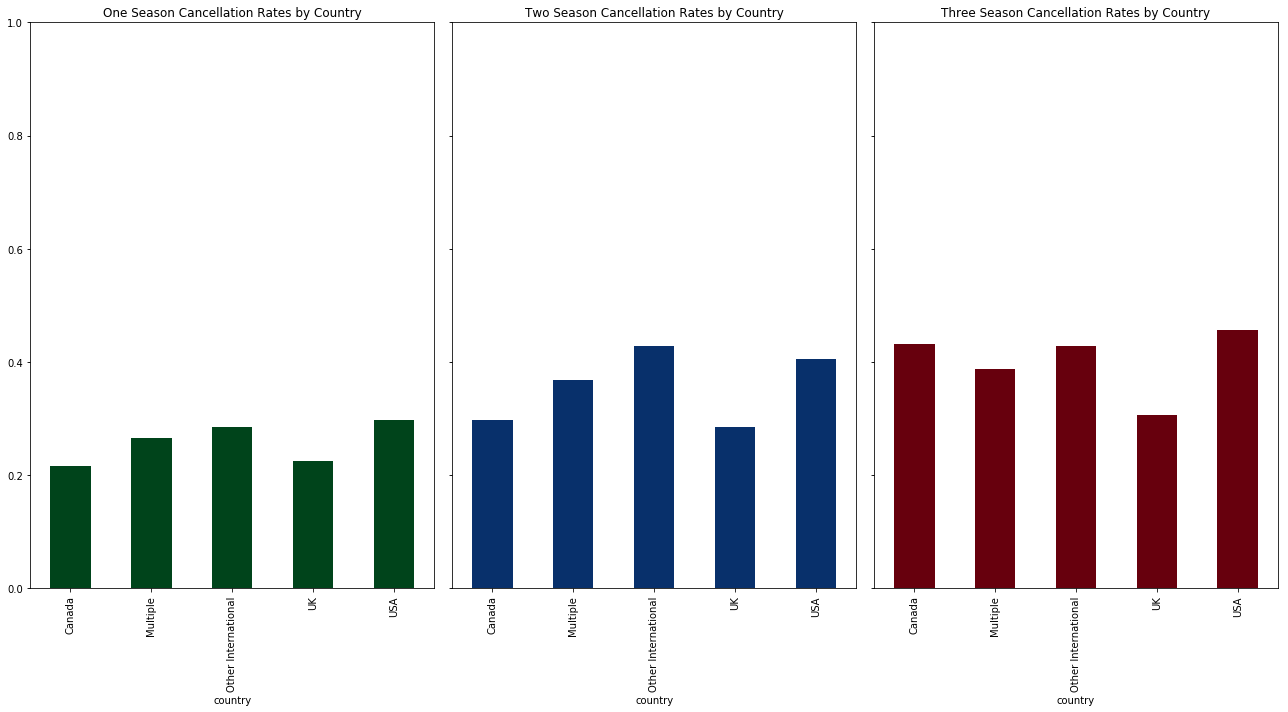

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,10),sharey=True)

ax1 = shows.groupby('country').mean()['one_season_cancel'].plot(kind='bar',cmap='Greens_r',ax=ax1)
ax1.set_title("One Season Cancellation Rates by Country")
ax1.set_ylim(0,1)

ax2 = shows.groupby('country').mean()['two_season_cancel'].plot(kind='bar',cmap='Blues_r',ax=ax2)
ax2.set_title("Two Season Cancellation Rates by Country")

ax3 = shows.groupby('country').mean()['three_season_cancel'].plot(kind='bar',cmap='Reds_r',ax=ax3)
ax3.set_title("Three Season Cancellation Rates by Country")

plt.tight_layout()
plt.show()

Interesting, looks like some international imports do better. Let's aggregate a little bit more.

In [17]:
def country_reclassifier(countries):
    if not isinstance(countries, str):
        new_class = np.nan
    elif len(countries.split(', ')) == 1:
        if countries in ['USA','UK','Canada']:
            new_class = countries
        else:
            new_class = 'Other International'
    elif len(countries.split(', ')) > 1:
        new_class = 'Multiple'
        
    return new_class

In [18]:
shows['country'] = shows['imdb_country'].apply(country_reclassifier)
shows['country'].value_counts()

USA                    1358
Multiple                 98
UK                       49
Canada                   37
Other International      14
Name: country, dtype: int64

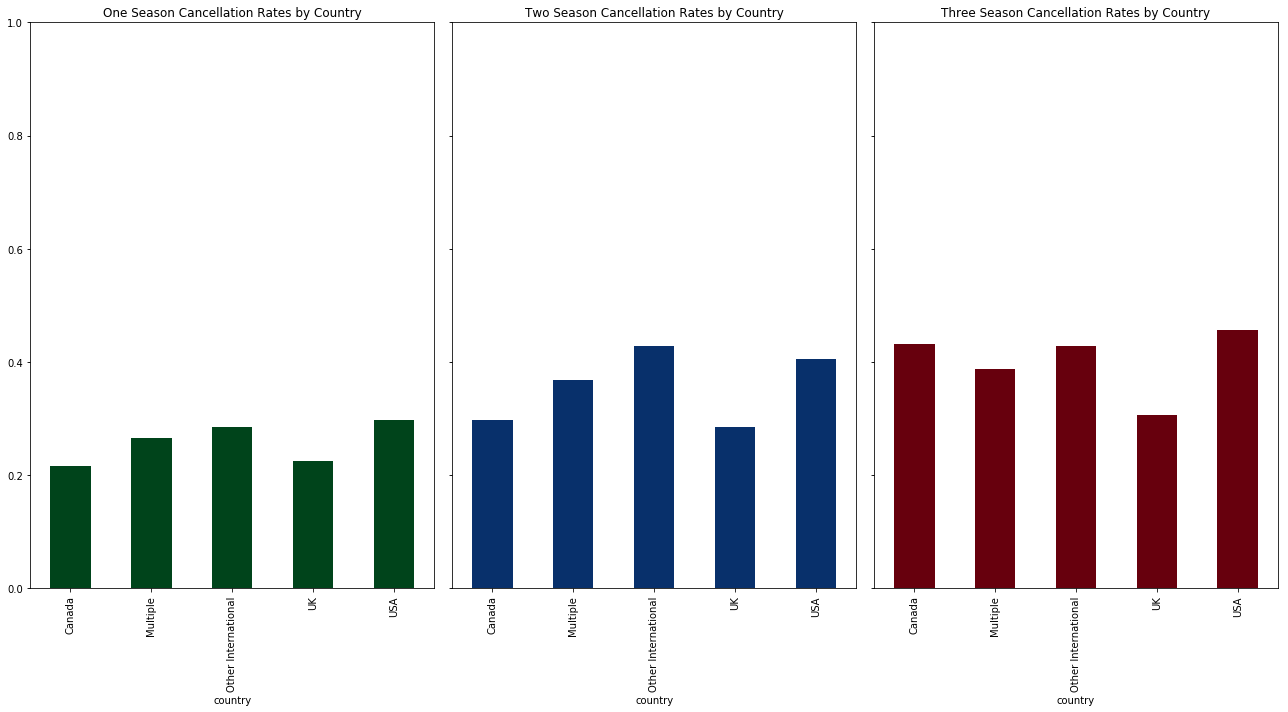

In [19]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,10),sharey=True)

ax1 = shows.groupby('country').mean()['one_season_cancel'].plot(kind='bar',cmap='Greens_r',ax=ax1)
ax1.set_title("One Season Cancellation Rates by Country")
ax1.set_ylim(0,1)

ax2 = shows.groupby('country').mean()['two_season_cancel'].plot(kind='bar',cmap='Blues_r',ax=ax2)
ax2.set_title("Two Season Cancellation Rates by Country")

ax3 = shows.groupby('country').mean()['three_season_cancel'].plot(kind='bar',cmap='Reds_r',ax=ax3)
ax3.set_title("Three Season Cancellation Rates by Country")

plt.tight_layout()
plt.show()

Looks like UK imports are the most durable, and in general international shows can fare pretty well relative to shows homegrown in the US. This is likely because many of the shows have already found success overseas and are therefore perhaps cheaper to license and may have built-in buzz/fanbases.

#### By IMDB Rating

In [223]:
shows['rounded_rating'] = np.round(shows['imdb_rating']*2)/2

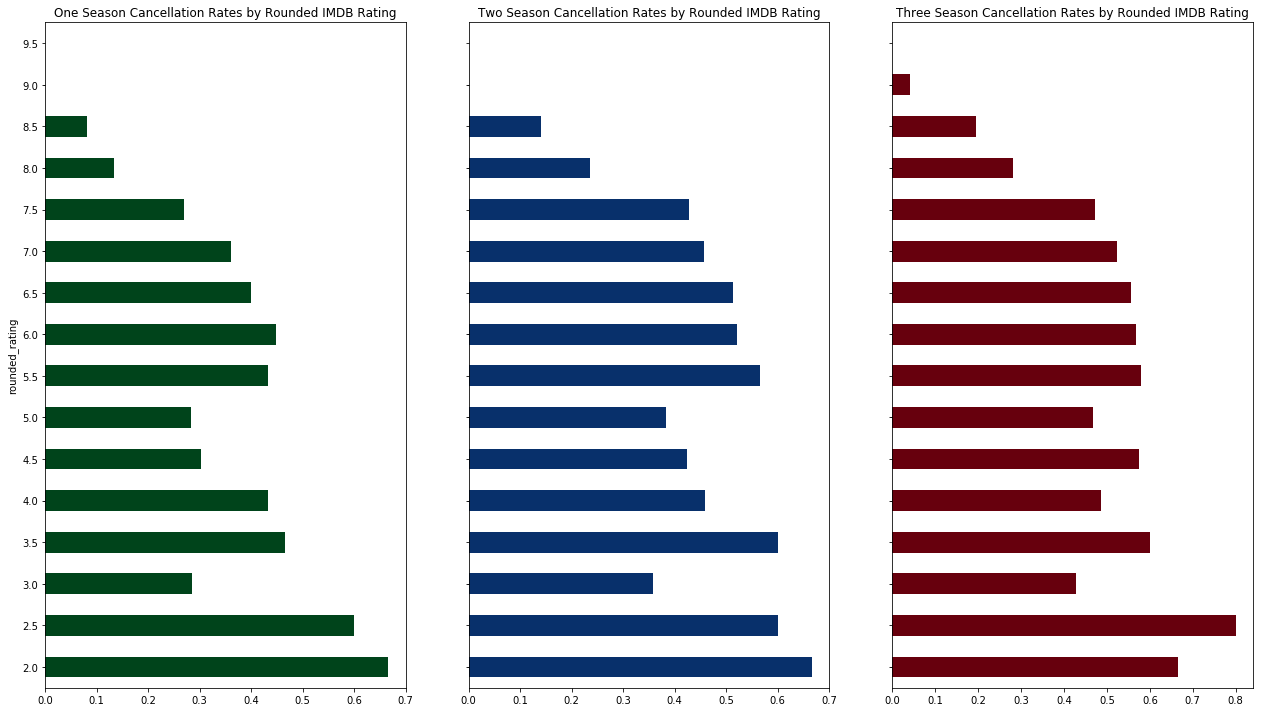

In [228]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,10),sharey=True)

ax1 = shows.groupby('rounded_rating').mean()['one_season_cancel'].plot(kind='barh',cmap='Greens_r',ax=ax1)
ax1.set_title("One Season Cancellation Rates by Rounded IMDB Rating")
ax1.set_ylim(0,1)

ax2 = shows.groupby('rounded_rating').mean()['two_season_cancel'].plot(kind='barh',cmap='Blues_r',ax=ax2)
ax2.set_title("Two Season Cancellation Rates by Rounded IMDB Rating")

ax3 = shows.groupby('rounded_rating').mean()['three_season_cancel'].plot(kind='barh',cmap='Reds_r',ax=ax3)
ax3.set_title("Three Season Cancellation Rates by Rounded IMDB Rating")

plt.tight_layout()
plt.show()

Unsurprisingly, there's definitely something to ratings and likelihood of cancellation. The less liked a show is, the more likely it is to get cancelled.

In [252]:
shows.imdb_rating.isnull().sum()

22

In [265]:
def rating_categorizer(rating):
    cat = 'blank'
    ratings = shows.imdb_rating.dropna()
    if rating is None:
        cat = np.nan
    elif rating <=np.percentile(ratings,25):
        cat = 'low'
    elif (rating > np.percentile(ratings,25)) & (rating < np.percentile(ratings,75)):
        cat = 'med'
    elif rating >= np.percentile(ratings,75):
        cat = 'high'
    
    return cat

In [268]:
shows['rating_cat'] = shows['imdb_rating'].apply(rating_categorizer)

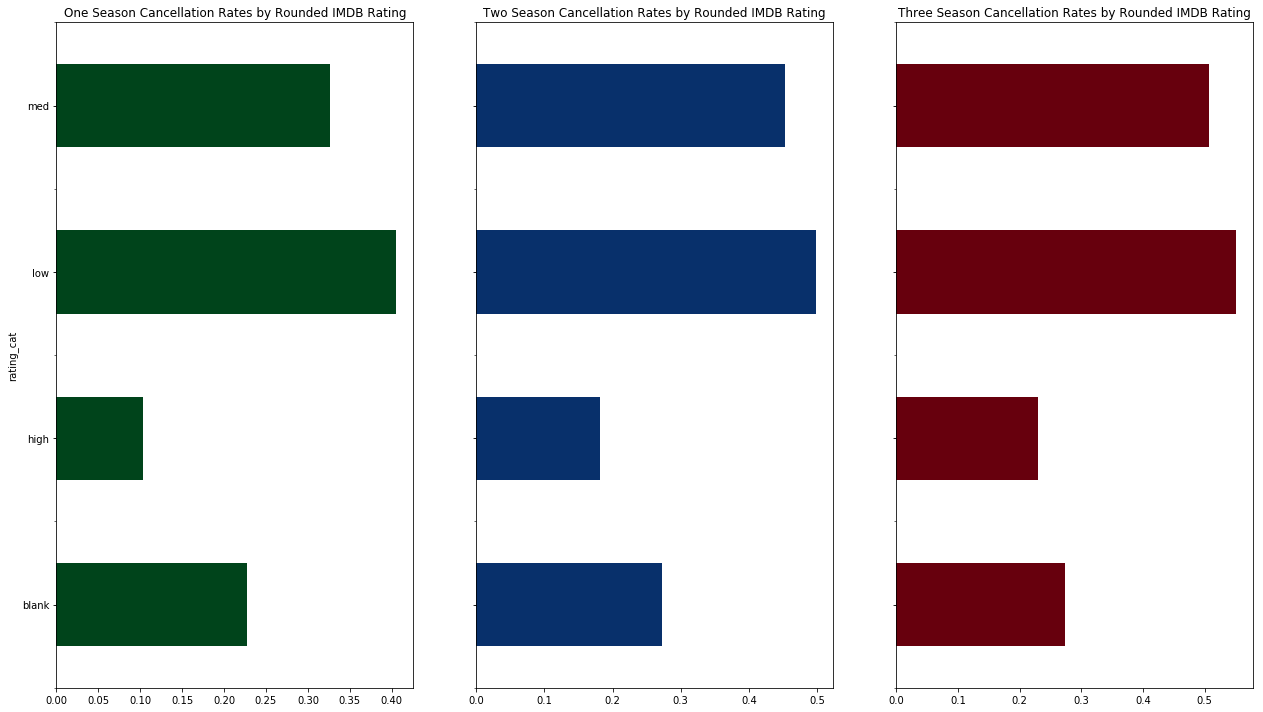

In [269]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,10),sharey=True)

ax1 = shows.groupby('rating_cat').mean()['one_season_cancel'].plot(kind='barh',cmap='Greens_r',ax=ax1)
ax1.set_title("One Season Cancellation Rates by Rounded IMDB Rating")
ax1.set_ylim(0,1)

ax2 = shows.groupby('rating_cat').mean()['two_season_cancel'].plot(kind='barh',cmap='Blues_r',ax=ax2)
ax2.set_title("Two Season Cancellation Rates by Rounded IMDB Rating")

ax3 = shows.groupby('rating_cat').mean()['three_season_cancel'].plot(kind='barh',cmap='Reds_r',ax=ax3)
ax3.set_title("Three Season Cancellation Rates by Rounded IMDB Rating")

plt.tight_layout()
plt.show()

In [270]:
shows.to_pickle("cleaned_onair_v2.pkl")

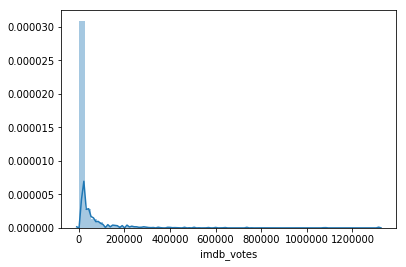

In [280]:
sns.distplot(shows.imdb_votes.dropna())
plt.show()

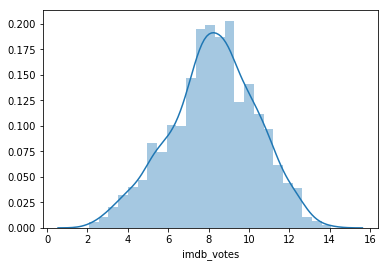

In [75]:
sns.distplot(np.log(shows.imdb_votes.dropna()))
plt.show()

The log of imdb_votes shows a nice normal distribution, so let's look at that.

In [76]:
shows['log_imdb_votes'] = np.log(shows['imdb_votes'])
shows['rounded_log_imdb_votes'] = np.round(shows['log_imdb_votes'])

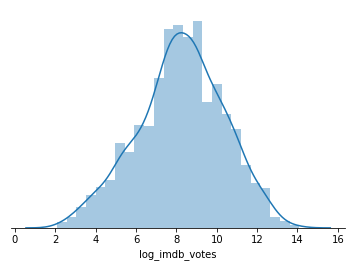

In [90]:
ax = plt.subplot(111)
ax = sns.distplot(shows['log_imdb_votes'].dropna())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig("Extras/logvotesdistplot.png")
plt.show()

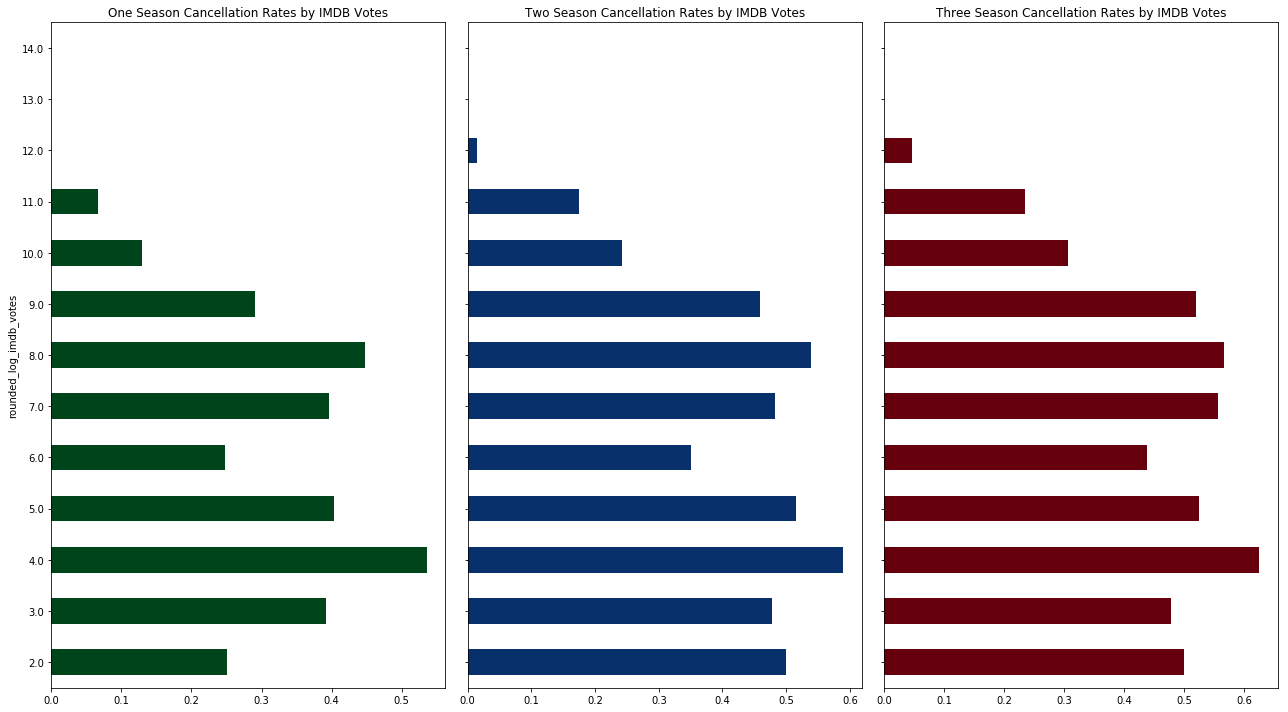

In [285]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,10),sharey=True)

ax1 = shows.groupby('rounded_log_imdb_votes').mean()['one_season_cancel'].plot(kind='barh',cmap='Greens_r',ax=ax1)
ax1.set_title("One Season Cancellation Rates by IMDB Votes")
ax1.set_ylim(0,1)

ax2 = shows.groupby('rounded_log_imdb_votes').mean()['two_season_cancel'].plot(kind='barh',cmap='Blues_r',ax=ax2)
ax2.set_title("Two Season Cancellation Rates by IMDB Votes")

ax3 = shows.groupby('rounded_log_imdb_votes').mean()['three_season_cancel'].plot(kind='barh',cmap='Reds_r',ax=ax3)
ax3.set_title("Three Season Cancellation Rates by IMDB Votes")

plt.tight_layout()
plt.show()

Cancellation rates also generally increase as the show has fewer votes.

In [5]:
#shows.to_pickle("cleaned_dataset_v3.pkl")
shows = pd.read_pickle("cleaned_dataset_v3.pkl")

Creating some new features based on votes...

In [11]:
shows['log_imdb_votes_per_season'] = shows['log_imdb_votes']/shows['yrs_run']
shows['rounded_log_votes_per_season'] = np.round(shows['log_imdb_votes_per_season']*2)/2

In [12]:
shows.to_pickle("cleaned_dataset_v4.pkl")

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


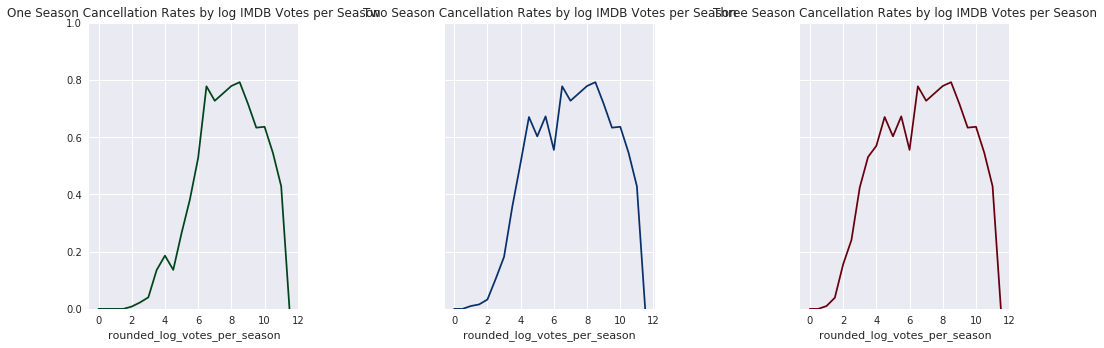

In [80]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5),sharey=True)

ax1 = shows.groupby('rounded_log_votes_per_season').mean()['one_season_cancel'].plot(kind='line',cmap='Greens_r',ax=ax1)
ax1.set_title("One Season Cancellation Rates by log IMDB Votes per Season")
ax1.set_ylim(0,1)

ax2 = shows.groupby('rounded_log_votes_per_season').mean()['two_season_cancel'].plot(kind='line',cmap='Blues_r',ax=ax2)
ax2.set_title("Two Season Cancellation Rates by log IMDB Votes per Season")

ax3 = shows.groupby('rounded_log_votes_per_season').mean()['three_season_cancel'].plot(kind='line',cmap='Reds_r',ax=ax3)
ax3.set_title("Three Season Cancellation Rates by log IMDB Votes per Season")

plt.tight_layout()
plt.show()

Both shows with very low log votes per season and very high values are less likely to be cancelled. The two cases probably correspond to very long running shows that are not collecting many votes as the divisor increases, and really popular shows that get tons of votes. It makes sense that both would have a slightly lesser cancellation rate.

In [71]:
common_lvps = shows.copy()
common_lvps['lvps_count'] = shows.groupby('rounded_log_votes_per_season').transform('count').iloc[:,0]
common_lvps = common_lvps[common_lvps['lvps_count']>30]

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


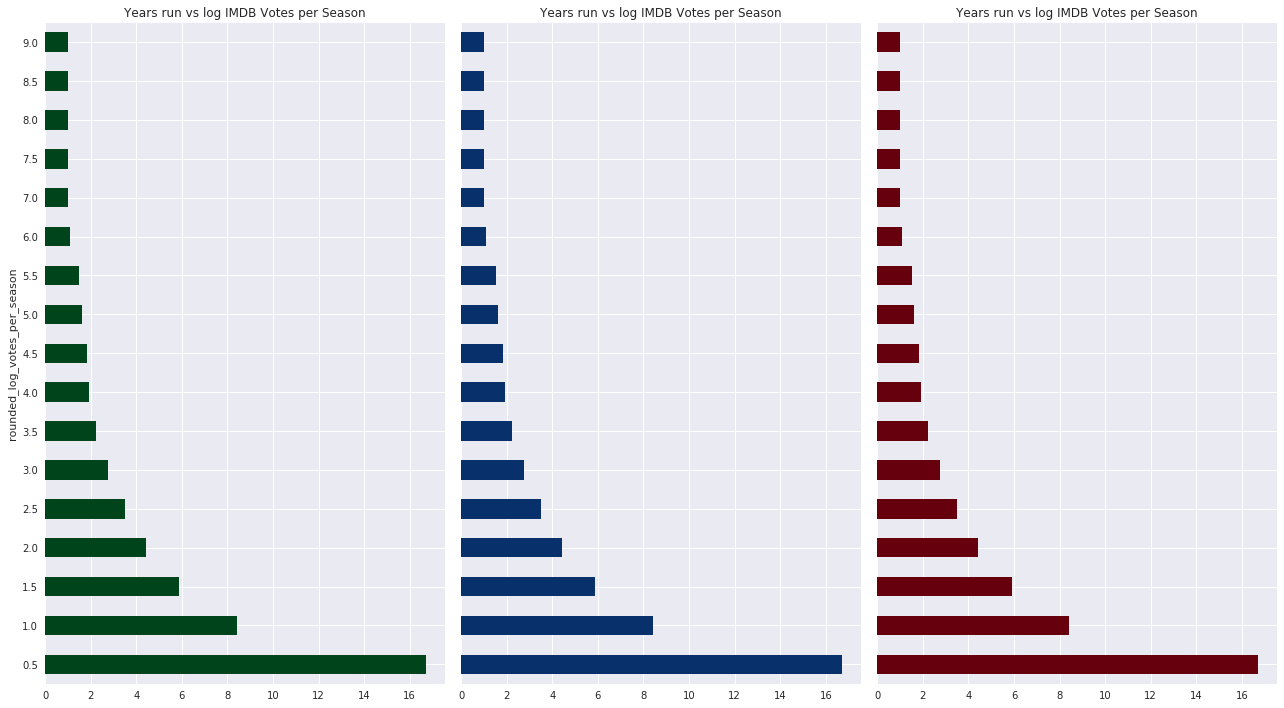

In [73]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,10),sharey=True)

ax1 = common_lvps.groupby('rounded_log_votes_per_season').mean()['yrs_run'].plot(kind='barh',cmap='Greens_r',ax=ax1)
ax1.set_title("Years run vs log IMDB Votes per Season")
ax1.set_ylim(0,1)

ax2 = common_lvps.groupby('rounded_log_votes_per_season').mean()['yrs_run'].plot(kind='barh',cmap='Blues_r',ax=ax2)
ax2.set_title("Years run vs log IMDB Votes per Season")

ax3 = common_lvps.groupby('rounded_log_votes_per_season').mean()['yrs_run'].plot(kind='barh',cmap='Reds_r',ax=ax3)
ax3.set_title("Years run vs log IMDB Votes per Season")

plt.tight_layout()
plt.show()

In [74]:
np.corrcoef(common_lvps.groupby('log_imdb_votes_per_season').mean()['yrs_run'].values,\
            common_lvps.groupby('log_imdb_votes_per_season').mean()['yrs_run'].index.values)[0][1]

-0.65277962335736262

Expanding on this point, in aggregate there is a medium negative correlation between log votes / season and likelihood of cancellation. It's worth noting that this will affect our IMDB-based models, in that they may not be as good at interpreting go-forward results based on log IMDB / season scores, since these are affected by the age of the show itself.

#### Crosstabs

In [20]:
pd.crosstab(shows['primary_genre'],shows['network_type'],normalize=False).apply(lambda r: r/r.sum(), axis=0)

network_type,basic_cable,broadcast,premium_cable,streaming
primary_genre,,,,
Comedy,0.251453,0.315542,0.431193,0.394161
Drama,0.363372,0.459969,0.486239,0.532847
Game Show,0.014535,0.051805,0.000000,0.000000
Reality,0.338663,0.161695,0.045872,0.043796
Sci-fi,0.001453,0.001570,0.000000,0.007299
Talk,0.030523,0.009419,0.036697,0.021898


Several interesting things here. Streaming and premium cable focus almost entirely on comedy and drama originals, while basic cable and broadcast have the most reality shows. Drama is the most popular genre for most of the original series in our dataset.

In [27]:
pd.crosstab(shows['rounded_rating'],shows['network_type'],normalize=False).apply(lambda r: r/r.sum(), axis=0)

network_type,basic_cable,broadcast,premium_cable,streaming
rounded_rating,,,,
2.0,0.002941,0.001587,0.000000,0.000000
2.5,0.005882,0.001587,0.000000,0.000000
3.0,0.010294,0.011111,0.000000,0.000000
3.5,0.014706,0.006349,0.000000,0.007576
4.0,0.032353,0.023810,0.000000,0.000000
4.5,0.029412,0.020635,0.000000,0.000000
5.0,0.057353,0.033333,0.000000,0.000000
5.5,0.058824,0.065079,0.009346,0.007576
6.0,0.091176,0.085714,0.046729,0.030303


Premium and streaming shows tend to be higher rated

In [45]:
network_ratings = pd.crosstab(shows['rounded_rating'],shows['network_type'],normalize=False)\
         .apply(lambda r: r/r.sum(), axis=0)

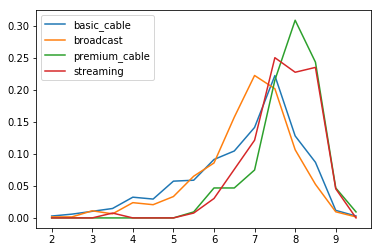

In [48]:
plt.plot(pd.crosstab(shows['rounded_rating'],shows['network_type'],normalize=False)\
         .apply(lambda r: r/r.sum(), axis=0))
plt.legend(network_ratings.columns)
plt.show()

Premium and streaming have many more shows in the excellent range in IMDB score (8+) than do basic cable or broadcast nets.

### Thoughts on target metric
We'll be using two season cancellation rate as our target label - why? It doesn't suffer from too much class imbalance as you can see above, which is useful when working with a small/medium sized dataset. Secondly, it's a better metric for show "failure" as we understand it than the same measure over one or three seasons. Since we're using this metric, we'll need to remove any shows from 2017 or 2018, which are ineligible, and I've manually gone and eliminated a few from the late part of 2016 as well.